In [1]:
from pycaret.classification import *
import os
import pandas as pd
import matplotlib.pyplot as plt
from prepro import *
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

In [2]:
path = './0-Data/'

In [3]:
train_csv = pd.read_csv(path + 'train.csv')
test_csv = pd.read_csv(path + 'test.csv')
submission = pd.read_csv(path + 'submission.csv')

print(train_csv.shape)
print(test_csv.shape)
print(submission.shape)

(11769, 15)
(5789, 13)
(5789, 2)


In [4]:
train_csv.head()
#test_csv.head()

,no,모델명,연월,연식,연료,주행거리,인승,최대출력(마력),기통,최대토크(kgm),구동방식,자동수동,국산/수입,신차가(만원),가격(만원)
0,0,기아 더 뉴 K7 2.4 GDI 프레스티지 스페셜,12/12(13년형),2013,가솔린,4만km,NaN,201.0,4.0,25.5,FF,NaN,국산,3141.0,1870
1,1,현대 YF쏘나타 2.0 Y20 LPi 프리미어,10월 3일,2010,LPG,9만km,NaN,157.0,NaN,20.0,FF,NaN,국산,NaN,700
2,2,현대 그랜져HG 220 디젤 프리미엄,14/09(15년형),2015,디젤,3만km,NaN,202.0,4.0,45.0,FF,NaN,국산,3389.0,2990
3,3,쌍용 뉴카이런 2.0 LV5 2WD 고급형,07/06(08년형),2008,디젤,16만km,NaN,151.0,4.0,33.8,FR,NaN,국산,2499.0,420
4,4,현대 뉴스타렉스 점보 밴 TCI 3인승 GX 윈도우밴 일반형,4월 3일,2004,디젤,16만km,3.0,103.0,NaN,24.0,FR,수동,국산,1445.0,450


# EDA

In [6]:
# colum 선별, 단위 정렬 


df.shape, df_test.shape

* colum 선별 및 단위 정렬 (11767, 8) (5789, 7)
label [1, 19900, 1459.6886207189598]
years [0, 49, 9.388629217302626]
distance [4.0, 760000.0, 100247.2584753973]
power [17.1, 453.0, 188.21604021800414]
torq [5.8, 140.0, 29.872607417243664]


((11767, 24), (5789, 23))

In [61]:
from sklearn.model_selection import train_test_split
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from tqdm import tqdm

def get_dl_dataset(train_csv, test_csv):
    train = tf_df(train_csv.drop([11764, 11755], axis=0))
    test  = tf_df(test_csv, mode='test')

    categoric = ['fuel', 'method', 'engine']
    train, test = categoric_process(train, test, categoric)

    numeric = ['label', 'years', 'distance','power', 'torq']
    minmax = get_minmax(train, test, numeric)
    train, test= numeric_process(train, test, numeric)
    
    train, test_x = train.to_numpy(), test.to_numpy()
    train_x, train_y = train[:, 1:], train[:,0]
        
    train_x = torch.tensor(train_x, dtype=torch.float32)
    train_y = torch.tensor(train_y, dtype=torch.float32)
    test_x = torch.tensor(test_x, dtype=torch.float32)
    
    train_x, valid_x, train_y, valid_y  = train_test_split(train_x, train_y, test_size=0.2, random_state=123)
    
    return train_x, train_y, valid_x, valid_y, test_x, minmax

def get_ml_dataset(train_csv, test_csv):
    train = tf_df(train_csv.drop([11764, 11755], axis=0))
    test  = tf_df(test_csv, mode='test')

    numeric = ['years', 'distance','power', 'torq']
    minmax = get_minmax(train, test, numeric)
    train, test= numeric_process(train, test, numeric)
    
    return train, test, minmax


# 모델 학습

In [10]:
train_x, train_y, valid_x, valid_y, test_x, minmax = get_dl_dataset(train_csv, test_csv)
print(train_x.shape, train_y.shape, valid_x.shape, valid_y.shape, test_x.shape)

DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'


N_MODEL = 10
N_EPOCH = 50
BATCH_SIZE = 64
LOADER_PARAM = {
    'batch_size': BATCH_SIZE,
    'num_workers': 4,
    'pin_memory': True
}

prediction_val = np.zeros((len(valid_x), 1), dtype=np.float32)
prediction = np.zeros((len(test_x), 1), dtype=np.float32)

class RMSELoss(nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.mse = nn.MSELoss()
        self.eps = eps

    def forward(self, yhat, y):
        loss = torch.sqrt(self.mse(yhat,y)+self.eps)
        return loss
        
for no in range(N_MODEL):

    train_loader = DataLoader(TensorDataset(train_x, train_y),
                              shuffle=True, drop_last=True, **LOADER_PARAM)

    valid_loader = DataLoader(TensorDataset(valid_x, torch.zeros((len(valid_x),), dtype=torch.float32)),
                              shuffle=False, drop_last=False, **LOADER_PARAM)

    test_loader = DataLoader(TensorDataset(test_x, torch.zeros((len(test_x),), dtype=torch.float32)),
                             shuffle=False, drop_last=False, **LOADER_PARAM)


    model = nn.Sequential(
        nn.Dropout(0.05),
        nn.Linear(23, 96, bias=False),
        nn.LeakyReLU(0.05, inplace=True),

        nn.Dropout(0.5),
        nn.Linear(96, 36, bias=False),
        nn.ReLU(inplace=True),

        nn.Dropout(0.5),
        nn.Linear(36, 12, bias=False),
        nn.ReLU(inplace=True),

        nn.Linear(12, 1)
    ).to(DEVICE)


    criterion = RMSELoss()
    optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=4e-2)
    scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
        optimizer, T_0=N_EPOCH // 4, eta_min=1.2e-5)

    model.train()
    for epoch in tqdm(range(N_EPOCH), desc='{:02d}/{:02d}'.format(no + 1, N_MODEL)):
        for idx, (xx, yy) in enumerate(train_loader):
            optimizer.zero_grad()
            xx, yy = xx.to(DEVICE), yy.to(DEVICE)
            pred = model(xx).squeeze()
            loss = criterion(pred, yy)
            loss.backward()
            optimizer.step()
            scheduler.step(epoch + idx / len(train_loader))
    print(loss)
    
    model.eval()
    with torch.no_grad():
        for idx, (xx, _) in enumerate(valid_loader):
            xx = xx.to(DEVICE)
            pred_val = model(xx).detach().to('cpu').numpy()
            prediction_val[BATCH_SIZE * idx:min(BATCH_SIZE * (idx + 1), len(prediction_val)), :] \
                += pred_val[:, :] / N_MODEL

01/10:   0%|          | 0/50 [00:00<?, ?it/s]

label [1, 19900, 1459.6886207189598]
years [0, 49, 9.388629217302626]
distance [4.0, 760000.0, 100247.2584753973]
power [17.1, 453.0, 188.21604021800414]
torq [5.8, 140.0, 29.872607417243664]
torch.Size([9413, 23]) torch.Size([9413]) torch.Size([2354, 23]) torch.Size([2354]) torch.Size([5789, 23])


01/10: 100%|██████████| 50/50 [00:12<00:00,  3.86it/s]

tensor(0.0527, grad_fn=<SqrtBackward>)



02/10: 100%|██████████| 50/50 [00:12<00:00,  3.91it/s]

tensor(0.0627, grad_fn=<SqrtBackward>)



03/10: 100%|██████████| 50/50 [00:12<00:00,  4.00it/s]

tensor(0.0407, grad_fn=<SqrtBackward>)



04/10: 100%|██████████| 50/50 [00:12<00:00,  3.91it/s]

tensor(0.0400, grad_fn=<SqrtBackward>)



05/10: 100%|██████████| 50/50 [00:12<00:00,  3.97it/s]

tensor(0.0214, grad_fn=<SqrtBackward>)



06/10: 100%|██████████| 50/50 [00:13<00:00,  3.80it/s]

tensor(0.0436, grad_fn=<SqrtBackward>)



07/10: 100%|██████████| 50/50 [00:13<00:00,  3.62it/s]

tensor(0.0440, grad_fn=<SqrtBackward>)



08/10: 100%|██████████| 50/50 [00:13<00:00,  3.79it/s]

tensor(0.0353, grad_fn=<SqrtBackward>)



09/10: 100%|██████████| 50/50 [00:13<00:00,  3.84it/s]

tensor(0.0477, grad_fn=<SqrtBackward>)



10/10: 100%|██████████| 50/50 [00:13<00:00,  3.79it/s]

tensor(0.0419, grad_fn=<SqrtBackward>)


In [12]:
prediction_val.shape, valid_y.shape

((2354, 1), torch.Size([2354]))

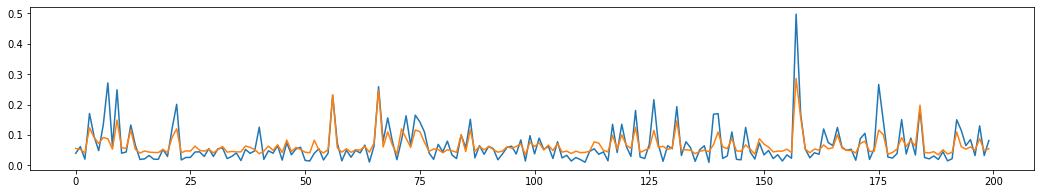

In [17]:
plt.figure(figsize=(18,3))
plt.plot(valid_y[:200])
plt.plot(prediction_val[:200])

[1, 19900, 1459.6886207189598]


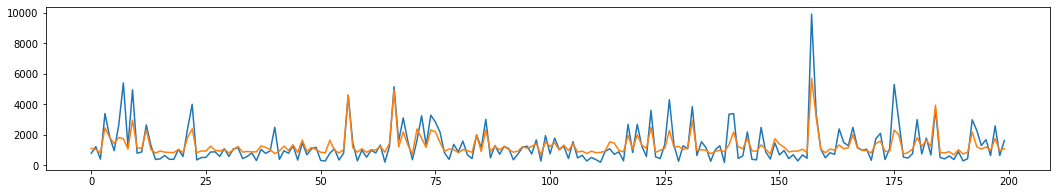

In [16]:
print(minmax['label'])
def get_cost(x, minmax):
    y = x*(minmax['label'][1]-minmax['label'][0])+minmax['label'][0]
    return y
plt.figure(figsize=(18,3))
plt.plot(get_cost(valid_y[:200], minmax))
plt.plot(get_cost(prediction_val[:200], minmax))

# ML

In [62]:
train, test, minmax = get_ml_dataset(train_csv, test_csv)
train.shape, test.shape

years [0, 49, 9.388629217302626]
distance [4.0, 760000.0, 100247.2584753973]
power [17.1, 453.0, 188.21604021800414]
torq [5.8, 140.0, 29.872607417243664]


((11767, 8), (5789, 7))

In [63]:
from pycaret.regression import *
data = setup(data = train, target = 'label', train_size=0.8)

,Description,Value
0,session_id,1818
1,Target,label
2,Original Data,"(11767, 8)"
3,Missing Values,True
4,Numeric Features,4
5,Categorical Features,3
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(9413, 28)"


* catboost, xgboost, gbr

In [77]:
catb = create_model('catboost')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,369.9,4.016e+05,633.7,0.7654,0.6153,10.29
1,362.1,6.361e+05,797.6,0.716,0.3663,0.2964
2,373.1,5.8e+05,761.6,0.7291,0.5789,6.156
3,350.9,4.147e+05,644,0.8035,0.3806,0.4034
4,362.2,4.622e+05,679.8,0.756,0.4758,4.01
5,372.3,4.309e+05,656.4,0.7714,0.5326,3.943
6,350,4.031e+05,634.9,0.7262,0.7067,14.19
7,356.9,4.47e+05,668.6,0.7687,0.6282,9.493
8,343.1,3.99e+05,631.7,0.8093,0.4983,5.601
9,314.5,2.893e+05,537.9,0.8404,0.4929,9.621


In [67]:
xgb = create_model('xgboost')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,380.5,4.403e+05,663.5,0.7428,0.6264,10.85
1,363.6,6.329e+05,795.5,0.7175,0.3793,0.2895
2,372.6,5.719e+05,756.2,0.7329,0.5765,6.174
3,357.4,4.545e+05,674.2,0.7846,0.4112,0.4098
4,368.2,4.807e+05,693.3,0.7462,0.491,4.024
5,387.4,4.961e+05,704.4,0.7368,0.5477,4.174
6,351.6,4.142e+05,643.6,0.7187,0.7119,14.66
7,349.4,4.402e+05,663.4,0.7723,0.6198,8.803
8,347.9,4.014e+05,633.6,0.8082,0.5016,5.633
9,328.3,3.599e+05,599.9,0.8014,0.4972,9.578


In [71]:
bagged_xgb = ensemble_model(xgb)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,371.2,4.217e+05,649.4,0.7537,0.6147,10.52
1,358.3,6.476e+05,804.7,0.7109,0.3633,0.2877
2,371.6,5.724e+05,756.6,0.7326,0.5719,5.95
3,358.3,4.36e+05,660.3,0.7934,0.3892,0.4186
4,362.8,4.558e+05,675.1,0.7594,0.4799,3.991
5,375.7,4.511e+05,671.6,0.7607,0.5358,4.013
6,348.5,4.1e+05,640.3,0.7216,0.7096,14.35
7,347.8,4.285e+05,654.6,0.7783,0.6213,9.238
8,343.3,4.05e+05,636.4,0.8064,0.4955,5.634
9,327,3.593e+05,599.4,0.8017,0.4912,9.435


In [78]:
bagged_catb = ensemble_model(catb)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,369.3,3.988e+05,631.5,0.767,0.6171,10.54
1,362.2,6.438e+05,802.4,0.7126,0.3695,0.2985
2,373.8,5.629e+05,750.3,0.7371,0.575,6.129
3,354.2,4.19e+05,647.3,0.8015,0.3822,0.4123
4,360.2,4.508e+05,671.4,0.762,0.4711,3.991
5,366.6,4.097e+05,640.1,0.7826,0.5296,3.779
6,351.8,4.076e+05,638.5,0.7232,0.7142,14.25
7,355,4.374e+05,661.4,0.7737,0.6262,9.538
8,345.5,4.005e+05,632.9,0.8086,0.495,5.744
9,319.1,3.083e+05,555.2,0.8299,0.489,9.596


# 하이퍼 파라미터 조정

In [73]:
tuned_xgb = tune_model(bagged_xgb)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,379,4.003e+05,632.7,0.7662,0.6179,9.88
1,369,6.662e+05,816.2,0.7026,0.3697,0.3088
2,372.7,5.739e+05,757.5,0.732,0.5758,6.043
3,363.4,4.066e+05,637.7,0.8073,0.3947,0.4325
4,362.2,4.359e+05,660.2,0.7699,0.4803,3.974
5,376,4.112e+05,641.3,0.7819,0.5403,4.107
6,353.3,4.06e+05,637.2,0.7243,0.7149,14.82
7,355.7,4.467e+05,668.3,0.7689,0.6224,9.099
8,351.8,4.23e+05,650.4,0.7978,0.5052,5.469
9,318.5,2.912e+05,539.6,0.8393,0.4911,9.36


In [76]:
bagged_xgb2 = ensemble_model(tuned_xgb)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,378.9,3.983e+05,631.1,0.7674,0.6216,9.949
1,373,6.831e+05,826.5,0.695,0.3729,0.3152
2,377.7,5.849e+05,764.8,0.7268,0.5818,6.058
3,373.8,4.287e+05,654.7,0.7969,0.4015,0.4471
4,366.1,4.436e+05,666,0.7658,0.4793,4.137
5,378.3,4.094e+05,639.9,0.7828,0.5462,4.162
6,353.3,3.981e+05,631,0.7297,0.7132,14.48
7,357.3,4.437e+05,666.1,0.7704,0.6231,8.875
8,362.1,4.579e+05,676.7,0.7811,0.508,5.536
9,327,3.133e+05,559.7,0.8271,0.4951,9.491


# 결과 보기 

In [80]:
final_xgb = finalize_model(tuned_xgb)

In [81]:
pred_xgb = predict_model(final_xgb)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extreme Gradient Boosting,299.7,2.656e+05,515.4,0.8459,0.4654,3.718


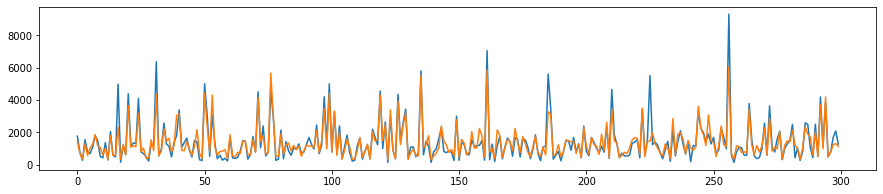

In [90]:
plot_result(pred_xgb['label'], pred_xgb['Label'], 300)

# 제출

In [88]:
def save_models(model, save_dir):

    pred = predict_model(model, data=test)
    pred = pred['Label']
    submission['가격(만원)'] = pred
    save_path = './results/%s/'%(save_dir)
    os.mkdir(save_path)
    submission.to_csv('%s/submission.csv'%save_path, index = False)
    save_model(model, '%s/model'%save_path)

In [89]:
save_models(final_xgb, 'sub-5')

Transformation Pipeline and Model Succesfully Saved


In [85]:
def rating(x):
    y = (100) * (2000 -x)/(2000)
    return y

def reverse(y):
    x = -((2000*y) / 100)+2000
    return x

In [86]:
rating(515)

74.25